In [1]:
import pandas as pd
from sklearn import linear_model
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

inputPath = '../input/'
outputPath = '../output/'

/datar10/opt/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
def create_strata(
    df=None,
    strata_list=[],
    stratum_name='stratum'):
    
    magnitude = 0
    block = pd.Series(np.zeros(shape=df.shape[0]), index=df.index).astype('int')
    for strata_var in strata_list:
        unit=1
        for stratum in df[strata_var].unique():
            block = block + pd.Series(df[strata_var].isin([stratum])) * unit * 10 ** magnitude
            unit += 1
        magnitude += 1
    df[stratum_name] = block    
    
    return 

def createWeights(
    df=None,
    uid = 'USI',
    treatment = 'is_treatment',
    stratum='stratum',
    weights='stratumWeights',
    totalN = 'stratumTotalN',
    treatedN = 'stratumTreatedN',
    prob = 'stratumProb'):
        
    df[totalN] = df[uid].groupby(by=df[stratum]).transform('nunique')
    df[treatedN] = df[treatment].groupby(by=df[stratum]).transform(np.sum)
    df[prob] = df[treatedN] / df[totalN]
    df[weights] = df[treatment] / df[prob] + (1 - df[treatment]) / (1 - df[prob])
    
    print('Strata:')
    print(df[['stratum', 'stratumTotalN', 'stratumTreatedN', 'stratumProb', 'stratumWeights']].groupby('stratum').agg(np.mean))

    if df['stratumWeights'].isna().any():
        print('WARNING: had to drop observations because of weights = NA')
        df.drop(index=df.loc[df['stratumWeights'].isna()].index, inplace=True)
    
    print('Weights')
    print(df[weights].describe())
    
    return

def randomThis(
    df=None, 
    groupId=None, 
    isTreated=None):
    
    treatList = df[[groupId, isTreated]].drop_duplicates().reset_index(drop=True).copy()
    treatList[isTreated] = treatList[isTreated].sample(frac=1).reset_index(drop=True)
    
    return df.drop(columns=[isTreated]).merge(treatList, on=groupId)

def randomInfer(
    df=None, 
    groupId=None, 
    isTreated=None, 
    X=None, 
    y=None,
    w=None,
    n=10000, 
    seed=42):
    
    if w == None:
        w = 'stratumWeights'
        df[w] = 1
    
    df = df[[groupId, isTreated, w] + X + y].copy()
    results = doReg(df=df, X=X, isTreated=isTreated, y=y, w=w)
    results['identifier'] = 'experiment'
    
    np.random.seed(seed)
    for i in range(n):
        rndDf = randomThis(df=df, groupId=groupId, isTreated=isTreated)
        rndResults = doReg(df=rndDf, X=X, isTreated=isTreated, y=y, w=w)
        rndResults['identifier'] = 'randomization'
        results = results.append(rndResults)
        
    pValue = (results.loc[results['identifier'] == 'randomization', 'is_treatment'] >= (
        results.loc[results['identifier'] == 'experiment', 'is_treatment'][0])).sum() / (
        results.shape[0] - 1)

    print('Results:')
    print(results.loc[results['identifier'] == 'experiment'])
    print('p-value for treatment =', pValue)

    ax = results.loc[results['identifier'] == 'randomization', 'is_treatment'].hist(bins=100)
    ax.axvline(results.loc[results['identifier'] == 'experiment', 'is_treatment'][0], color='red')
    
    return results, pValue

def doReg(
    df=None,
    isTreated=None,
    X=None, 
    y=None,
    w=None):
   
    rndX = X + [isTreated]
    regr = linear_model.LinearRegression()
    regr.fit(df[rndX], df[y], df[w])
    rndResults = {x[0]: x[1] for x in zip(rndX, regr.coef_[0])}
    rndResults['Intercept'] = regr.intercept_
    return pd.DataFrame(rndResults)
    
    

# Analysis of 14-day results

## Load data, create strata and weights

### Levels

In [3]:
df14Level = pd.read_csv(inputPath + 'studentsAttendance14.csv', index_col=0)

df14Level['stratum2'] = (df14Level['max_transit'] / 60)  > 50
df14Level['stratum3'] = df14Level['num_children'] > 2
create_strata(df=df14Level, strata_list=['stratum2', 'stratum3', 'site_location'])
df14Level.drop(columns=['stratum2', 'stratum3'], inplace=True)
createWeights(df=df14Level)
print('Number of observations for regressions:', df14Level.shape[0])

Strata:
         stratumTotalN  stratumTreatedN  stratumProb  stratumWeights
stratum                                                             
111               19.0               10     0.526316             2.0
112                7.0                3     0.428571             2.0
121               21.0               11     0.523810             2.0
122               24.0               15     0.625000             2.0
211               14.0                7     0.500000             2.0
212               12.0                7     0.583333             2.0
221               36.0               16     0.444444             2.0
222               29.0               16     0.551724             2.0
311               25.0               13     0.520000             2.0
312               15.0                6     0.400000             2.0
321               16.0                9     0.562500             2.0
322               13.0                3     0.230769             2.0
411               16.0    

### Differences

In [4]:
df14Diff = pd.read_csv(inputPath + 'studentsAttendance14Diff.csv', index_col=0)
df14Diff['stratum2'] = (df14Diff['max_transit'] / 60)  > 50
df14Diff['stratum3'] = df14Diff['num_children'] > 2
create_strata(df=df14Diff, strata_list=['stratum2', 'stratum3', 'site_location'])
df14Diff.drop(columns=['stratum2', 'stratum3'], inplace=True)
createWeights(df=df14Diff)
print('Number of observations for regressions:', df14Diff.shape[0])

Strata:
         stratumTotalN  stratumTreatedN  stratumProb  stratumWeights
stratum                                                             
111                9.0                4     0.444444             2.0
112                4.0                2     0.500000             2.0
121               12.0                8     0.666667             2.0
122               21.0               12     0.571429             2.0
211               13.0                7     0.538462             2.0
212                9.0                5     0.555556             2.0
221               33.0               16     0.484848             2.0
222               18.0                9     0.500000             2.0
311               18.0               12     0.666667             2.0
312               13.0                5     0.384615             2.0
321               13.0                9     0.692308             2.0
322                6.0                3     0.500000             2.0
411               15.0    

## Regressions

### Without other regressors

#### Levels

Results:
   is_treatment  Intercept  identifier
0      0.038068   0.851142  experiment
p-value for treatment = 0.086


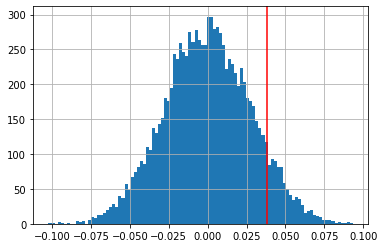

In [5]:
X = []
y = ['attendanceRate']
w = 'stratumWeights'
results14LevelBase, pValue14LevelBase = randomInfer(df=df14Level, groupId='hmis_id', isTreated='is_treatment', X=X, y=y, w=w)

#### Differences

Results:
   attendanceRateBefore  is_treatment  Intercept  identifier
0              0.552189      0.024119   0.382921  experiment
p-value for treatment = 0.1556


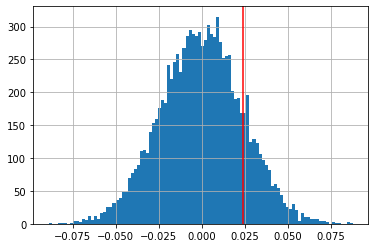

In [6]:
X = ['attendanceRateBefore']
y = ['attendanceRate']
w = 'stratumWeights'
results14DiffBase, pValue14DiffBase = randomInfer(df=df14Diff, groupId='hmis_id', isTreated='is_treatment', X=X, y=y, w=w)

### With additional regressors

Student-level: age
Household-level: number of adults, number of children, has car

#### Levels

Results:
        age  num_adults  num_children   has_car  is_treatment  Intercept  \
0 -0.005123    0.005212      0.021535  0.001972      0.043605    0.82196   

   identifier  
0  experiment  
p-value for treatment = 0.0613


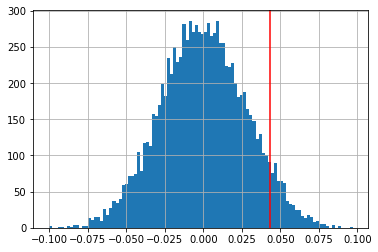

In [7]:
X = ['age', 'num_adults', 'num_children', 'has_car']
y = ['attendanceRate']
w = 'stratumWeights'
results14LevelAdditional, pValue14LevelAdditional = randomInfer(df=df14Level, groupId='hmis_id', isTreated='is_treatment', X=X, y=y, w=w)

#### Differences

Results:
        age  num_adults  num_children   has_car  attendanceRateBefore  \
0 -0.001121   -0.003495       0.01864 -0.018952               0.54235   

   is_treatment  Intercept  identifier  
0      0.026473   0.358716  experiment  
p-value for treatment = 0.1375


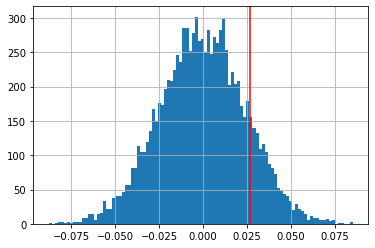

In [15]:
X = ['age', 'num_adults', 'num_children', 'has_car', 'attendanceRateBefore']
y = ['attendanceRate']
w = 'stratumWeights'
results14DiffAdditional, pValue14DiffAdditional = randomInfer(df=df14Diff, groupId='hmis_id', isTreated='is_treatment', X=X, y=y, w=w)

# Analysis of 30-day results

## Load data, create strata and weights

### Levels

In [9]:
df30Level = pd.read_csv(inputPath + 'studentsAttendance30.csv', index_col=0)

df30Level['stratum2'] = (df30Level['max_transit'] / 60)  > 50
df30Level['stratum3'] = df30Level['num_children'] > 2
create_strata(df=df30Level, strata_list=['stratum2', 'stratum3', 'site_location'])
df30Level.drop(columns=['stratum2', 'stratum3'], inplace=True)
createWeights(df=df30Level)
print('Number of observations for regressions:', df30Level.shape[0])

Strata:
         stratumTotalN  stratumTreatedN  stratumProb  stratumWeights
stratum                                                             
111                 19               10     0.526316             2.0
112                  7                3     0.428571             2.0
121                 22               11     0.500000             2.0
122                 19               10     0.526316             2.0
211                 14                7     0.500000             2.0
212                 12                6     0.500000             2.0
221                 34               14     0.411765             2.0
222                 26               13     0.500000             2.0
311                 23               13     0.565217             2.0
312                 15                6     0.400000             2.0
321                 16                9     0.562500             2.0
322                 10                0     0.000000             NaN
411                 15    

### Differences

In [10]:
df30Diff = pd.read_csv(inputPath + 'studentsAttendance30Diff.csv', index_col=0)
df30Diff['stratum2'] = (df30Diff['max_transit'] / 60)  > 50
df30Diff['stratum3'] = df30Diff['num_children'] > 2
create_strata(df=df30Diff, strata_list=['stratum2', 'stratum3', 'site_location'])
df30Diff.drop(columns=['stratum2', 'stratum3'], inplace=True)
createWeights(df=df30Diff)
print('Number of observations for regressions:', df30Diff.shape[0])

Strata:
         stratumTotalN  stratumTreatedN  stratumProb  stratumWeights
stratum                                                             
111                  9                4     0.444444             2.0
112                  4                2     0.500000             2.0
121                  7                6     0.857143             2.0
122                 13                4     0.307692             2.0
211                 13                7     0.538462             2.0
212                  7                4     0.571429             2.0
221                 30               13     0.433333             2.0
222                 14                6     0.428571             2.0
311                 16               12     0.750000             2.0
312                 12                4     0.333333             2.0
321                 13                9     0.692308             2.0
322                  3                0     0.000000             NaN
411                 14    

## Regressions

### Without other regressors

#### Levels

Results:
   is_treatment  Intercept  identifier
0      0.036637   0.844107  experiment
p-value for treatment = 0.0954


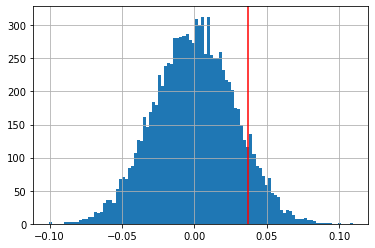

In [11]:
X = []
y = ['attendanceRate']
w = 'stratumWeights'
results30LevelBase, pValue30LevelBase = randomInfer(df=df30Level, groupId='hmis_id', isTreated='is_treatment', X=X, y=y, w=w)

#### Differences

Results:
   attendanceRateBefore  is_treatment  Intercept  identifier
0              0.607913      0.008119    0.33852  experiment
p-value for treatment = 0.3731


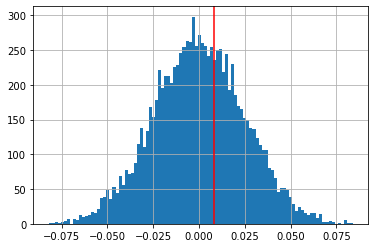

In [12]:
X = ['attendanceRateBefore']
y = ['attendanceRate']
w = 'stratumWeights'
results30DiffBase, pValue30DiffBase = randomInfer(df=df30Diff, groupId='hmis_id', isTreated='is_treatment', X=X, y=y, w=w)

### With additional regressors

Student-level: age
Household-level: number of adults, number of children, has car

#### Level

Results:
        age  num_adults  num_children   has_car  is_treatment  Intercept  \
0 -0.006075    0.032222      0.018366  0.016726      0.037915   0.796026   

   identifier  
0  experiment  
p-value for treatment = 0.0864


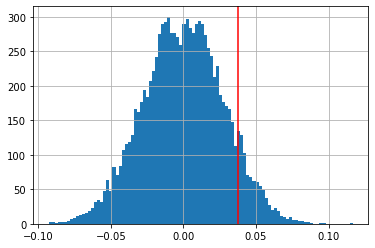

In [16]:
X = ['age', 'num_adults', 'num_children', 'has_car']
y = ['attendanceRate']
w = 'stratumWeights'
results30LevelAdditional, pValue30LevelAdditional = randomInfer(df=df30Level, groupId='hmis_id', isTreated='is_treatment', X=X, y=y, w=w)

#### Differences

Results:
        age  num_adults  num_children   has_car  attendanceRateBefore  \
0 -0.004952    0.024942      0.022396 -0.020389              0.594199   

   is_treatment  Intercept  identifier  
0       0.01082   0.304427  experiment  
p-value for treatment = 0.3362


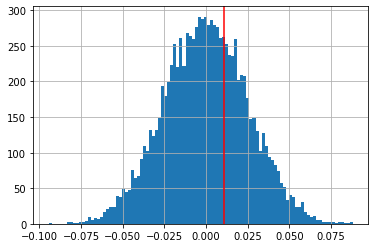

In [13]:
X = ['age', 'num_adults', 'num_children', 'has_car', 'attendanceRateBefore']
y = ['attendanceRate']
w = 'stratumWeights'
results30DiffAdditional, pValue30DiffAdditional = randomInfer(df=df30Diff, groupId='hmis_id', isTreated='is_treatment', X=X, y=y, w=w)

In [17]:
for fileName in [(results14LevelBase, 'results14LevelBase'), 
                 (results30LevelBase, 'results30LevelBase'), 
                 (results14DiffBase, 'results14DiffBase'), 
                 (results30DiffBase, 'results30DiffBase'),
                 (results14LevelAdditional, 'results14LevelAdditional'), 
                 (results30LevelAdditional, 'results30LevelAdditional'), 
                 (results14DiffAdditional, 'results14DiffAdditional'), 
                 (results30DiffAdditional, 'results30DiffAdditional')]:
    fileName[0].to_csv('../output/' + fileName[1] + '.csv')